In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-19 19:28:18.893370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 19:28:18.897490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 19:28:18.897673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 19:28:18.898302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="MobileNetV2/MobileNetV2 history"+current_time,dpi=300)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
def preview_dataset(dataset):
    for image, label in dataset.take(20):
        print(image)
preview_dataset(ds_test)

tf.Tensor(
[[[[0.03614027 0.03346189 0.02842654]
   [0.03614027 0.03346189 0.02842654]
   [0.03431898 0.03353332 0.0267838 ]
   ...
   [0.03642597 0.03578316 0.03114063]
   [0.03710449 0.03664024 0.03192629]
   [0.03817584 0.03717592 0.03478323]]

  [[0.03614027 0.03346189 0.02842654]
   [0.03614027 0.03346189 0.02842654]
   [0.03431898 0.03353332 0.0267838 ]
   ...
   [0.03642597 0.03578316 0.03114063]
   [0.03710449 0.03664024 0.03192629]
   [0.03817584 0.03717592 0.03478323]]

  [[0.03599743 0.03356903 0.02764088]
   [0.03599743 0.03356903 0.02764088]
   [0.03567602 0.03349761 0.02789086]
   ...
   [0.03589029 0.03460467 0.02910506]
   [0.0356046  0.03524748 0.02917649]
   [0.03631883 0.03581887 0.0307478 ]]

  ...

  [[0.03942576 0.03792586 0.03453325]
   [0.03942576 0.03792586 0.03453325]
   [0.03710449 0.03749732 0.0316406 ]
   ...
   [0.04635383 0.04667524 0.04488965]
   [0.04467538 0.04553246 0.04285408]
   [0.04342547 0.04342547 0.04096136]]

  [[0.03842583 0.03764017 0.034390

tf.Tensor(
[[[[0.03267624 0.02649811 0.01628455]
   [0.03267624 0.02649811 0.01628455]
   [0.03060496 0.02499821 0.01467752]
   ...
   [0.03228341 0.02289122 0.01467752]
   [0.03274766 0.02310549 0.01539176]
   [0.03249768 0.02299836 0.01549889]]

  [[0.03267624 0.02649811 0.01628455]
   [0.03267624 0.02649811 0.01628455]
   [0.03060496 0.02499821 0.01467752]
   ...
   [0.03228341 0.02289122 0.01467752]
   [0.03274766 0.02310549 0.01539176]
   [0.03249768 0.02299836 0.01549889]]

  [[0.03139061 0.02564103 0.0173559 ]
   [0.03139061 0.02564103 0.0173559 ]
   [0.03142633 0.02760517 0.0170345 ]
   ...
   [0.03206914 0.02267695 0.01439183]
   [0.03242626 0.02242697 0.01485608]
   [0.03260481 0.02303407 0.01557032]]

  ...

  [[0.03431898 0.03096207 0.02149846]
   [0.03431898 0.03096207 0.02149846]
   [0.03631883 0.02989072 0.02317692]
   ...
   [0.03324762 0.02385544 0.01678452]
   [0.03324762 0.02431969 0.0170345 ]
   [0.03346189 0.02360546 0.01624884]]

  [[0.03792586 0.03364046 0.026069

2022-11-19 19:28:19.583425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.07)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [7]:
def augment_data(image,label):
  #image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  #image=augment_hue(image)
  image=augment_saturation(image)
  #image=augment_brightness(image)
  #image=augment_contrast(image)


  return image,label

In [8]:
ds_train_augmented = ds_train.map(augment_data)

In [9]:
resnet = tf.keras.applications.MobileNetV2(include_top = False,
                                          input_shape = (64,64,3),
                                          classes = 10)

model = tf.keras.models.Sequential(resnet)
model.add(tf.keras.layers.Dropout(0.75))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

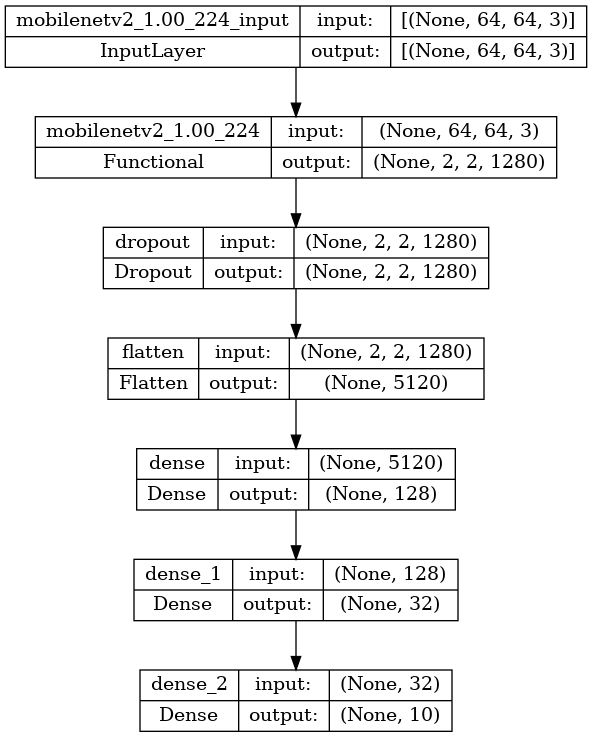

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.000005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [11]:
history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_validation,
    callbacks = tf.keras.callbacks.ModelCheckpoint(
        "MobileNetV2/MobileNetv2 epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
    )
)

Epoch 1/100


2022-11-19 19:28:25.101979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


169/169 [==============================] - ETA: 0s - loss: 3.5582 - sparse_categorical_accuracy: 0.1194

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:01-val_loss:2.801/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:01-val_loss:2.801/assets


169/169 [==============================] - 29s 139ms/step - loss: 3.5582 - sparse_categorical_accuracy: 0.1194 - val_loss: 2.8007 - val_sparse_categorical_accuracy: 0.1193
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 2.8376 - sparse_categorical_accuracy: 0.1495

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:02-val_loss:2.646/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:02-val_loss:2.646/assets


169/169 [==============================] - 23s 134ms/step - loss: 2.8376 - sparse_categorical_accuracy: 0.1495 - val_loss: 2.6461 - val_sparse_categorical_accuracy: 0.0811
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 2.5318 - sparse_categorical_accuracy: 0.1777

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:03-val_loss:2.422/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:03-val_loss:2.422/assets


169/169 [==============================] - 23s 135ms/step - loss: 2.5318 - sparse_categorical_accuracy: 0.1777 - val_loss: 2.4215 - val_sparse_categorical_accuracy: 0.1033
Epoch 4/100
169/169 [==============================] - ETA: 0s - loss: 2.3571 - sparse_categorical_accuracy: 0.2130

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:04-val_loss:2.359/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:04-val_loss:2.359/assets


169/169 [==============================] - 23s 135ms/step - loss: 2.3571 - sparse_categorical_accuracy: 0.2130 - val_loss: 2.3586 - val_sparse_categorical_accuracy: 0.0833
Epoch 5/100
168/169 [============================>.] - ETA: 0s - loss: 2.2049 - sparse_categorical_accuracy: 0.2551

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:05-val_loss:2.331/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:05-val_loss:2.331/assets


169/169 [==============================] - 23s 136ms/step - loss: 2.2040 - sparse_categorical_accuracy: 0.2555 - val_loss: 2.3307 - val_sparse_categorical_accuracy: 0.2074
Epoch 6/100
169/169 [==============================] - 11s 64ms/step - loss: 2.0665 - sparse_categorical_accuracy: 0.2972 - val_loss: 2.3647 - val_sparse_categorical_accuracy: 0.1344
Epoch 7/100
169/169 [==============================] - 11s 64ms/step - loss: 1.9240 - sparse_categorical_accuracy: 0.3431 - val_loss: 2.4289 - val_sparse_categorical_accuracy: 0.1293
Epoch 8/100
169/169 [==============================] - 11s 63ms/step - loss: 1.7972 - sparse_categorical_accuracy: 0.3812 - val_loss: 2.4526 - val_sparse_categorical_accuracy: 0.1333
Epoch 9/100
169/169 [==============================] - 11s 63ms/step - loss: 1.6773 - sparse_categorical_accuracy: 0.4218 - val_loss: 2.4583 - val_sparse_categorical_accuracy: 0.1330
Epoch 10/100
169/169 [==============================] - 11s 64ms/step - loss: 1.5641 - sparse_ca

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:19-val_loss:2.330/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:19-val_loss:2.330/assets


169/169 [==============================] - 21s 127ms/step - loss: 0.7877 - sparse_categorical_accuracy: 0.7494 - val_loss: 2.3296 - val_sparse_categorical_accuracy: 0.2778
Epoch 20/100
168/169 [============================>.] - ETA: 0s - loss: 0.7320 - sparse_categorical_accuracy: 0.7667

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:20-val_loss:2.258/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:20-val_loss:2.258/assets


169/169 [==============================] - 21s 127ms/step - loss: 0.7323 - sparse_categorical_accuracy: 0.7667 - val_loss: 2.2577 - val_sparse_categorical_accuracy: 0.3159
Epoch 21/100
168/169 [============================>.] - ETA: 0s - loss: 0.6914 - sparse_categorical_accuracy: 0.7847

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:21-val_loss:2.232/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:21-val_loss:2.232/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.6918 - sparse_categorical_accuracy: 0.7845 - val_loss: 2.2320 - val_sparse_categorical_accuracy: 0.3415
Epoch 22/100
168/169 [============================>.] - ETA: 0s - loss: 0.6525 - sparse_categorical_accuracy: 0.7954

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:22-val_loss:2.161/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:22-val_loss:2.161/assets


169/169 [==============================] - 21s 126ms/step - loss: 0.6529 - sparse_categorical_accuracy: 0.7953 - val_loss: 2.1613 - val_sparse_categorical_accuracy: 0.3948
Epoch 23/100
168/169 [============================>.] - ETA: 0s - loss: 0.6148 - sparse_categorical_accuracy: 0.8066

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:23-val_loss:2.051/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:23-val_loss:2.051/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.6144 - sparse_categorical_accuracy: 0.8068 - val_loss: 2.0505 - val_sparse_categorical_accuracy: 0.4404
Epoch 24/100
168/169 [============================>.] - ETA: 0s - loss: 0.5741 - sparse_categorical_accuracy: 0.8204

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:24-val_loss:1.974/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:24-val_loss:1.974/assets


169/169 [==============================] - 21s 126ms/step - loss: 0.5742 - sparse_categorical_accuracy: 0.8205 - val_loss: 1.9745 - val_sparse_categorical_accuracy: 0.4833
Epoch 25/100
168/169 [============================>.] - ETA: 0s - loss: 0.5475 - sparse_categorical_accuracy: 0.8307

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:25-val_loss:1.884/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:25-val_loss:1.884/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.5475 - sparse_categorical_accuracy: 0.8306 - val_loss: 1.8842 - val_sparse_categorical_accuracy: 0.5300
Epoch 26/100
168/169 [============================>.] - ETA: 0s - loss: 0.5163 - sparse_categorical_accuracy: 0.8416

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:26-val_loss:1.709/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:26-val_loss:1.709/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.5165 - sparse_categorical_accuracy: 0.8415 - val_loss: 1.7087 - val_sparse_categorical_accuracy: 0.5659
Epoch 27/100
169/169 [==============================] - ETA: 0s - loss: 0.4977 - sparse_categorical_accuracy: 0.8447

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:27-val_loss:1.552/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:27-val_loss:1.552/assets


169/169 [==============================] - 22s 130ms/step - loss: 0.4977 - sparse_categorical_accuracy: 0.8447 - val_loss: 1.5521 - val_sparse_categorical_accuracy: 0.6100
Epoch 28/100
168/169 [============================>.] - ETA: 0s - loss: 0.4803 - sparse_categorical_accuracy: 0.8483

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:28-val_loss:1.374/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:28-val_loss:1.374/assets


169/169 [==============================] - 22s 130ms/step - loss: 0.4806 - sparse_categorical_accuracy: 0.8482 - val_loss: 1.3739 - val_sparse_categorical_accuracy: 0.6537
Epoch 29/100
168/169 [============================>.] - ETA: 0s - loss: 0.4566 - sparse_categorical_accuracy: 0.8571

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:29-val_loss:1.192/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:29-val_loss:1.192/assets


169/169 [==============================] - 22s 133ms/step - loss: 0.4557 - sparse_categorical_accuracy: 0.8574 - val_loss: 1.1924 - val_sparse_categorical_accuracy: 0.6981
Epoch 30/100
168/169 [============================>.] - ETA: 0s - loss: 0.4303 - sparse_categorical_accuracy: 0.8655

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:30-val_loss:1.070/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:30-val_loss:1.070/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.4311 - sparse_categorical_accuracy: 0.8653 - val_loss: 1.0701 - val_sparse_categorical_accuracy: 0.7304
Epoch 31/100
168/169 [============================>.] - ETA: 0s - loss: 0.4171 - sparse_categorical_accuracy: 0.8697

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:31-val_loss:0.920/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:31-val_loss:0.920/assets


169/169 [==============================] - 22s 130ms/step - loss: 0.4180 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.9204 - val_sparse_categorical_accuracy: 0.7574
Epoch 32/100
169/169 [==============================] - ETA: 0s - loss: 0.3955 - sparse_categorical_accuracy: 0.8776

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:32-val_loss:0.783/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:32-val_loss:0.783/assets


169/169 [==============================] - 24s 145ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.7830 - val_sparse_categorical_accuracy: 0.7915
Epoch 33/100
168/169 [============================>.] - ETA: 0s - loss: 0.3858 - sparse_categorical_accuracy: 0.8810

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:33-val_loss:0.682/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:33-val_loss:0.682/assets


169/169 [==============================] - 24s 142ms/step - loss: 0.3853 - sparse_categorical_accuracy: 0.8811 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.8148
Epoch 34/100
168/169 [============================>.] - ETA: 0s - loss: 0.3631 - sparse_categorical_accuracy: 0.8872

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:34-val_loss:0.585/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:34-val_loss:0.585/assets


169/169 [==============================] - 22s 132ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.5850 - val_sparse_categorical_accuracy: 0.8433
Epoch 35/100
168/169 [============================>.] - ETA: 0s - loss: 0.3571 - sparse_categorical_accuracy: 0.8890

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:35-val_loss:0.521/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:35-val_loss:0.521/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.3573 - sparse_categorical_accuracy: 0.8888 - val_loss: 0.5213 - val_sparse_categorical_accuracy: 0.8556
Epoch 36/100
168/169 [============================>.] - ETA: 0s - loss: 0.3438 - sparse_categorical_accuracy: 0.8934

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:36-val_loss:0.471/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:36-val_loss:0.471/assets


169/169 [==============================] - 22s 129ms/step - loss: 0.3439 - sparse_categorical_accuracy: 0.8934 - val_loss: 0.4705 - val_sparse_categorical_accuracy: 0.8711
Epoch 37/100
169/169 [==============================] - ETA: 0s - loss: 0.3345 - sparse_categorical_accuracy: 0.8950

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:37-val_loss:0.422/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:37-val_loss:0.422/assets


169/169 [==============================] - 23s 139ms/step - loss: 0.3345 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8841
Epoch 38/100
168/169 [============================>.] - ETA: 0s - loss: 0.3353 - sparse_categorical_accuracy: 0.8971

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:38-val_loss:0.386/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:38-val_loss:0.386/assets


169/169 [==============================] - 22s 133ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.3860 - val_sparse_categorical_accuracy: 0.8919
Epoch 39/100
168/169 [============================>.] - ETA: 0s - loss: 0.3083 - sparse_categorical_accuracy: 0.9035

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:39-val_loss:0.360/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:39-val_loss:0.360/assets


169/169 [==============================] - 22s 128ms/step - loss: 0.3087 - sparse_categorical_accuracy: 0.9034 - val_loss: 0.3600 - val_sparse_categorical_accuracy: 0.8989
Epoch 40/100
168/169 [============================>.] - ETA: 0s - loss: 0.3107 - sparse_categorical_accuracy: 0.9045

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:40-val_loss:0.336/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:40-val_loss:0.336/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.3114 - sparse_categorical_accuracy: 0.9044 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.9081
Epoch 41/100
169/169 [==============================] - ETA: 0s - loss: 0.2860 - sparse_categorical_accuracy: 0.9094

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:41-val_loss:0.321/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:41-val_loss:0.321/assets


169/169 [==============================] - 22s 132ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.3210 - val_sparse_categorical_accuracy: 0.9111
Epoch 42/100
169/169 [==============================] - ETA: 0s - loss: 0.2788 - sparse_categorical_accuracy: 0.9121

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:42-val_loss:0.310/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:42-val_loss:0.310/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.2788 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.3099 - val_sparse_categorical_accuracy: 0.9178
Epoch 43/100
168/169 [============================>.] - ETA: 0s - loss: 0.2776 - sparse_categorical_accuracy: 0.9128

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:43-val_loss:0.299/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:43-val_loss:0.299/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.2773 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.2986 - val_sparse_categorical_accuracy: 0.9185
Epoch 44/100
169/169 [==============================] - ETA: 0s - loss: 0.2646 - sparse_categorical_accuracy: 0.9170

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:44-val_loss:0.289/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:44-val_loss:0.289/assets


169/169 [==============================] - 23s 136ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.2890 - val_sparse_categorical_accuracy: 0.9219
Epoch 45/100
169/169 [==============================] - ETA: 0s - loss: 0.2587 - sparse_categorical_accuracy: 0.9177

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:45-val_loss:0.283/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:45-val_loss:0.283/assets


169/169 [==============================] - 23s 136ms/step - loss: 0.2587 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.2833 - val_sparse_categorical_accuracy: 0.9233
Epoch 46/100
168/169 [============================>.] - ETA: 0s - loss: 0.2567 - sparse_categorical_accuracy: 0.9189

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:46-val_loss:0.275/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:46-val_loss:0.275/assets


169/169 [==============================] - 22s 133ms/step - loss: 0.2564 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.2753 - val_sparse_categorical_accuracy: 0.9248
Epoch 47/100
168/169 [============================>.] - ETA: 0s - loss: 0.2407 - sparse_categorical_accuracy: 0.9241

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:47-val_loss:0.271/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:47-val_loss:0.271/assets


169/169 [==============================] - 22s 133ms/step - loss: 0.2402 - sparse_categorical_accuracy: 0.9243 - val_loss: 0.2712 - val_sparse_categorical_accuracy: 0.9259
Epoch 48/100
169/169 [==============================] - ETA: 0s - loss: 0.2329 - sparse_categorical_accuracy: 0.9265

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:48-val_loss:0.265/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:48-val_loss:0.265/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.2329 - sparse_categorical_accuracy: 0.9265 - val_loss: 0.2650 - val_sparse_categorical_accuracy: 0.9274
Epoch 49/100
168/169 [============================>.] - ETA: 0s - loss: 0.2249 - sparse_categorical_accuracy: 0.9279

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:49-val_loss:0.260/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:49-val_loss:0.260/assets


169/169 [==============================] - 22s 132ms/step - loss: 0.2251 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.2604 - val_sparse_categorical_accuracy: 0.9281
Epoch 50/100
168/169 [============================>.] - ETA: 0s - loss: 0.2171 - sparse_categorical_accuracy: 0.9287

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:50-val_loss:0.257/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:50-val_loss:0.257/assets


169/169 [==============================] - 22s 132ms/step - loss: 0.2167 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.2573 - val_sparse_categorical_accuracy: 0.9270
Epoch 51/100
169/169 [==============================] - ETA: 0s - loss: 0.2245 - sparse_categorical_accuracy: 0.9276

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:51-val_loss:0.255/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:51-val_loss:0.255/assets


169/169 [==============================] - 23s 137ms/step - loss: 0.2245 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.2545 - val_sparse_categorical_accuracy: 0.9270
Epoch 52/100
169/169 [==============================] - ETA: 0s - loss: 0.2095 - sparse_categorical_accuracy: 0.9345

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:52-val_loss:0.253/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:52-val_loss:0.253/assets


169/169 [==============================] - 23s 134ms/step - loss: 0.2095 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.2532 - val_sparse_categorical_accuracy: 0.9270
Epoch 53/100
168/169 [============================>.] - ETA: 0s - loss: 0.2017 - sparse_categorical_accuracy: 0.9369

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:53-val_loss:0.250/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:53-val_loss:0.250/assets


169/169 [==============================] - 22s 131ms/step - loss: 0.2016 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9281
Epoch 54/100
169/169 [==============================] - ETA: 0s - loss: 0.1962 - sparse_categorical_accuracy: 0.9364

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:54-val_loss:0.250/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:54-val_loss:0.250/assets


169/169 [==============================] - 22s 132ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9364 - val_loss: 0.2495 - val_sparse_categorical_accuracy: 0.9289
Epoch 55/100
168/169 [============================>.] - ETA: 0s - loss: 0.1942 - sparse_categorical_accuracy: 0.9389

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:55-val_loss:0.248/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:55-val_loss:0.248/assets


169/169 [==============================] - 21s 126ms/step - loss: 0.1940 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.2479 - val_sparse_categorical_accuracy: 0.9300
Epoch 56/100
168/169 [============================>.] - ETA: 0s - loss: 0.1807 - sparse_categorical_accuracy: 0.9399

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:56-val_loss:0.245/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:56-val_loss:0.245/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.2451 - val_sparse_categorical_accuracy: 0.9315
Epoch 57/100
168/169 [============================>.] - ETA: 0s - loss: 0.1870 - sparse_categorical_accuracy: 0.9409

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:57-val_loss:0.243/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:57-val_loss:0.243/assets


169/169 [==============================] - 21s 124ms/step - loss: 0.1870 - sparse_categorical_accuracy: 0.9408 - val_loss: 0.2427 - val_sparse_categorical_accuracy: 0.9322
Epoch 58/100
168/169 [============================>.] - ETA: 0s - loss: 0.1768 - sparse_categorical_accuracy: 0.9423

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:58-val_loss:0.240/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:58-val_loss:0.240/assets


169/169 [==============================] - 21s 126ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9424 - val_loss: 0.2404 - val_sparse_categorical_accuracy: 0.9315
Epoch 59/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.2413 - val_sparse_categorical_accuracy: 0.9322
Epoch 60/100
168/169 [============================>.] - ETA: 0s - loss: 0.1625 - sparse_categorical_accuracy: 0.9460

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:60-val_loss:0.236/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:60-val_loss:0.236/assets


169/169 [==============================] - 21s 124ms/step - loss: 0.1623 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.2362 - val_sparse_categorical_accuracy: 0.9330
Epoch 61/100
168/169 [============================>.] - ETA: 0s - loss: 0.1588 - sparse_categorical_accuracy: 0.9482

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:61-val_loss:0.234/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:61-val_loss:0.234/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1596 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.2343 - val_sparse_categorical_accuracy: 0.9344
Epoch 62/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.2352 - val_sparse_categorical_accuracy: 0.9341
Epoch 63/100
168/169 [============================>.] - ETA: 0s - loss: 0.1471 - sparse_categorical_accuracy: 0.9514

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:63-val_loss:0.233/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:63-val_loss:0.233/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.2330 - val_sparse_categorical_accuracy: 0.9337
Epoch 64/100
168/169 [============================>.] - ETA: 0s - loss: 0.1409 - sparse_categorical_accuracy: 0.9531

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:64-val_loss:0.231/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:64-val_loss:0.231/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.2308 - val_sparse_categorical_accuracy: 0.9356
Epoch 65/100
168/169 [============================>.] - ETA: 0s - loss: 0.1423 - sparse_categorical_accuracy: 0.9539

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:65-val_loss:0.229/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:65-val_loss:0.229/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1423 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.2294 - val_sparse_categorical_accuracy: 0.9356
Epoch 66/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.9562 - val_loss: 0.2302 - val_sparse_categorical_accuracy: 0.9344
Epoch 67/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1363 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.2303 - val_sparse_categorical_accuracy: 0.9356
Epoch 68/100
168/169 [============================>.] - ETA: 0s - loss: 0.1314 - sparse_categorical_accuracy: 0.9568

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:68-val_loss:0.229/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:68-val_loss:0.229/assets


169/169 [==============================] - 21s 126ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9569 - val_loss: 0.2289 - val_sparse_categorical_accuracy: 0.9356
Epoch 69/100
168/169 [============================>.] - ETA: 0s - loss: 0.1268 - sparse_categorical_accuracy: 0.9587

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:69-val_loss:0.226/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:69-val_loss:0.226/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.2263 - val_sparse_categorical_accuracy: 0.9359
Epoch 70/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.2264 - val_sparse_categorical_accuracy: 0.9348
Epoch 71/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.2278 - val_sparse_categorical_accuracy: 0.9356
Epoch 72/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9378
Epoch 73/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1179 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.2264 - val_sparse_categorical_accuracy: 0.9378
Epoch 74/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1056 - spars

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:76-val_loss:0.225/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:76-val_loss:0.225/assets


169/169 [==============================] - 21s 126ms/step - loss: 0.1006 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.2253 - val_sparse_categorical_accuracy: 0.9404
Epoch 77/100
168/169 [============================>.] - ETA: 0s - loss: 0.1025 - sparse_categorical_accuracy: 0.9656

INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:77-val_loss:0.224/assets


INFO:tensorflow:Assets written to: MobileNetV2/MobileNetv2 epoch:77-val_loss:0.224/assets


169/169 [==============================] - 21s 125ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.2242 - val_sparse_categorical_accuracy: 0.9404
Epoch 78/100
169/169 [==============================] - 10s 60ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.2253 - val_sparse_categorical_accuracy: 0.9407
Epoch 79/100
169/169 [==============================] - 10s 60ms/step - loss: 0.1007 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.2286 - val_sparse_categorical_accuracy: 0.9415
Epoch 80/100
169/169 [==============================] - 10s 60ms/step - loss: 0.0935 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.2282 - val_sparse_categorical_accuracy: 0.9415
Epoch 81/100
169/169 [==============================] - 10s 60ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.2288 - val_sparse_categorical_accuracy: 0.9400
Epoch 82/100
169/169 [==============================] - 10s 60ms/step - loss: 0.0906 - spars


Test accuracy: 0.9503703713417053


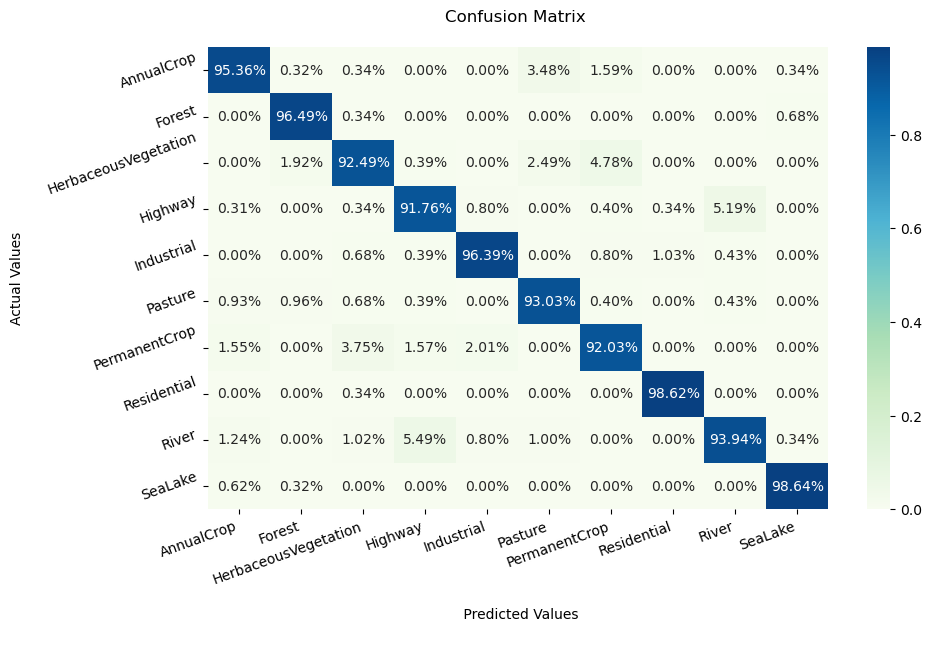

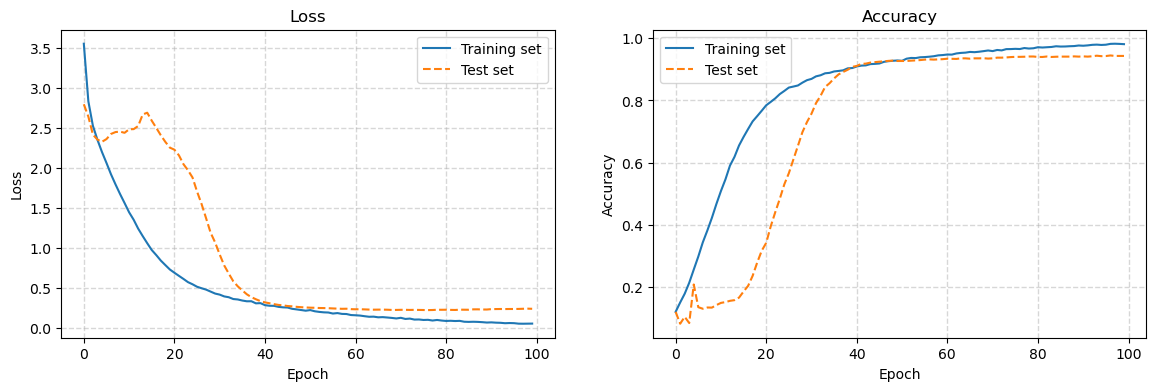

In [12]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="MobileNetV2/MobileNetV2 confusion matrix"+current_time,dpi=300)
render_training_history(history)
